## Языковое моделирование

Языковая модель оценивает вероятность встретить последовательность слов $(w_1,\cdots ,w_n)$.

$$P(w_1, \cdots, w_n) = \prod\limits_{i = 1}^n P (w_i|w_1, \cdots, w_{i-1})$$

Для каждого слова последовательности предсказывается вероятность встретить его в тексте при условии, что известно предыдущее слово: $w_2$ при условии $w_1$, $w_3$ при условии $w_1$ и $w_2$, и т.д.

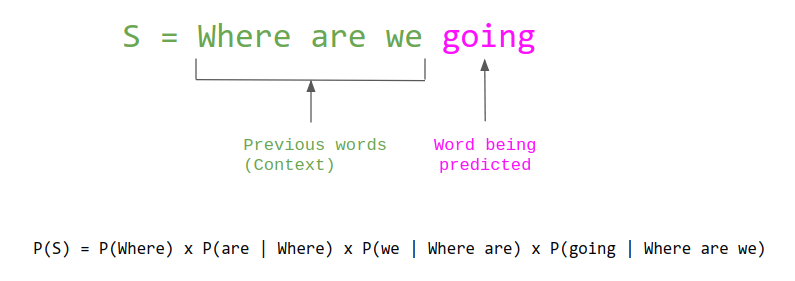

📌 Как называется языковая модель, которая учитывает только одно предыдущее слово? А предыдущие два слова?

Мы рассмотрим языковые модели на основе рекуррентных нейронных сетей. Они должны хорошо подходить для этой задачи, поскольку они проходят по последовательности и запоминают порядок элементов.

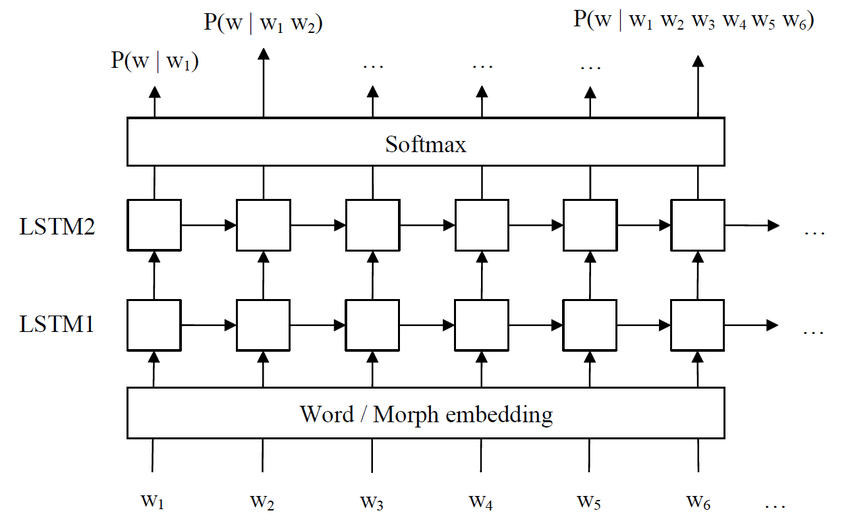

- Embedding

Есть входная последовательность из $n$ элементов. Мы пропускаем ее через слой эмбеддингов, который каждому элементу последовательности сопоставляет векторное представление.

- LSTM1, LSTM2

На вход ячейки LSTM поступает вектор заданной длины. Скрытое состояние (краткосрочная память, hidden state) элемента $w_i$ передается на следующую ячейку того же слоя вместе с элементом $w_{i+1}$. На рисунке представлено 2 слоя LSTM. Следовательно, скрытое состояние элемента $w_i$ на слое LSTM1 передается также на следующий слой LSTM2.

- Softmax

Выход каждого слоя — контекстуализированный эмбеддинг элемента последовательности. Однако в задаче языкового моделирования мы должны получать распределение  вероятностей для следующего элемента при условии текущей последовательности. Это должен быть вектор вероятностей, длина которого равна количеству элементов в словаре. Необходимо пропустить векторы элементов через линейный слой и применить функцию активации softmax.

Для элемента $w_i$ предсказывается вероятность элемента $w_{i+1}$ с учетом предшествующей последовательности $w_1, \cdots, w_i$ (по прошлому предсказываем будущее).

📌 Какое распределение вероятностей мы ожидаем для последовательности "where are we ___"?

После предсказания вероятностей необходимо оценить качество и посчитать размер ошибки. В качестве правильных ответов мы используем те же обучающие данные, но сдвинутые на 1 шаг. Это достигается за счет добавления тегов начала START и конца END последовательности.

Для элемента START правильным ответом будет элемент h, для h — e, для e — l, и т.д.

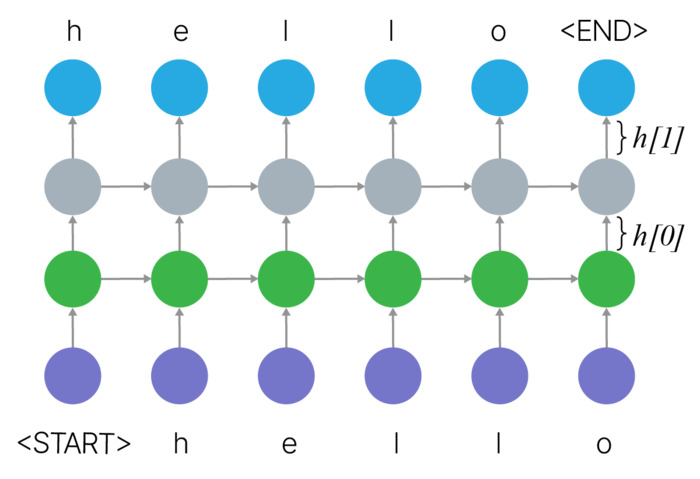

📌 В чем особенность обучающих данных для языкового моделирования по сравнению с задачей классификации?

### Загрузка и подготовка данных

Мы обучим языковую модель на уровне символов.

В качестве обучающих данных будем использовать [корпус названий динозавров](https://www.kaggle.com/datasets/swimmingwhale/dinosaur-island).

После обучения эта модель будет способна порождать новые имена динозавров, похожие на существующие.

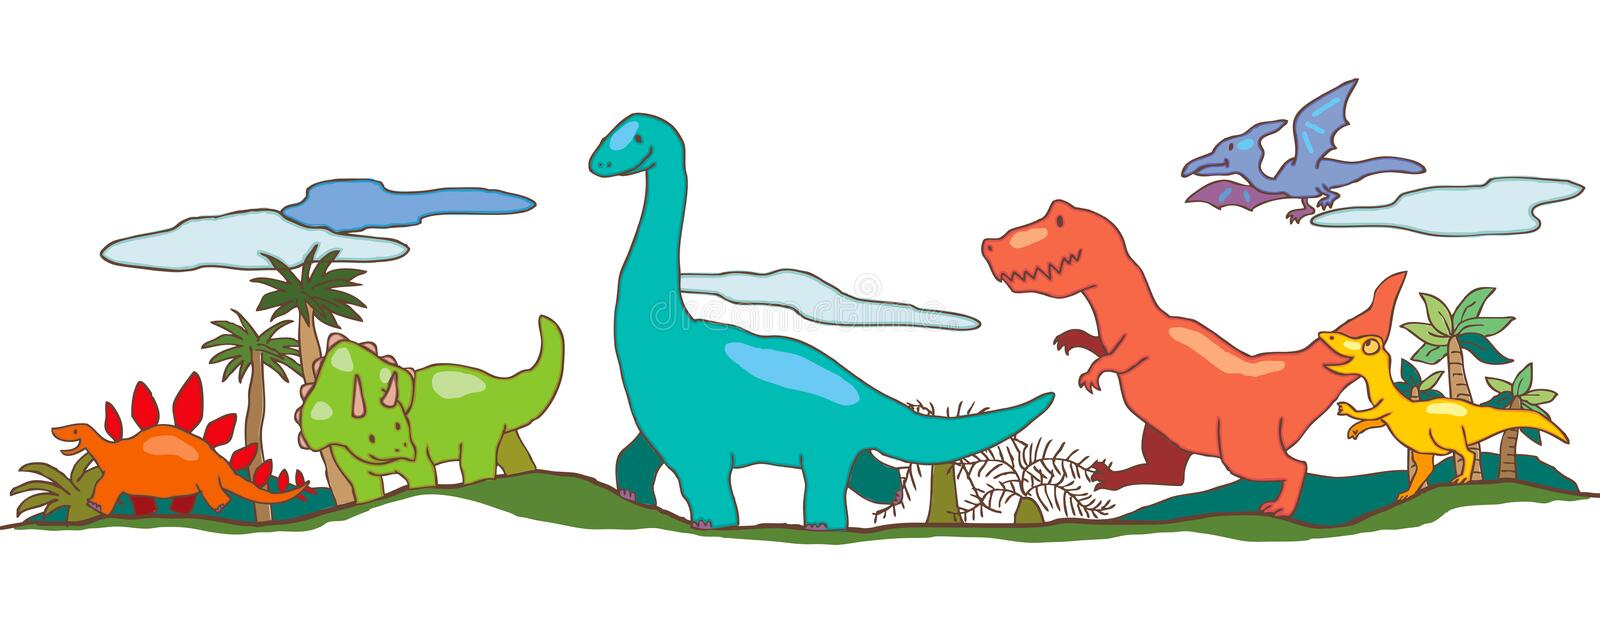

Загрузим данных и посмотрим на содержание файла.

In [ ]:
!wget https://raw.githubusercontent.com/Xeanst/NN_in_compling/main/06_language_modeling/dinos.txt

--2024-02-06 14:44:59--  https://raw.githubusercontent.com/Xeanst/NN_in_compling/main/06_language_modeling/dinos.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19909 (19K) [text/plain]
Saving to: ‘dinos.txt’

dinos.txt           100%[===================>]  19.44K  --.-KB/s    in 0.001s  

2024-02-06 14:44:59 (27.4 MB/s) - ‘dinos.txt’ saved [19909/19909]



In [ ]:
!head dinos.txt

Aachenosaurus
Aardonyx
Abdallahsaurus
Abelisaurus
Abrictosaurus
Abrosaurus
Abydosaurus
Acanthopholis
Achelousaurus
Acheroraptor


In [ ]:
!tail dinos.txt

Zhuchengtyrannus
Ziapelta
Zigongosaurus
Zizhongosaurus
Zuniceratops
Zunityrannus
Zuolong
Zuoyunlong
Zupaysaurus
Zuul

Создадим класс `DinoDataset`, наследник класса `Dataset`.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
class DinosDataset(Dataset):
  def __init__(self):
    super().__init__()
    with open('dinos.txt') as f:
      content = f.read().lower()
      self.vocab = sorted(set(content)) + ['<','>'] # добавляем в словарь все буквы, а также спецсимволы начала и конца
      self.vocab_size = len(self.vocab) # определяем размер словаря
      self.lines = content.splitlines() # разбиваем по строкам
    self.char2id = {char:id for id,char in enumerate(self.vocab)} # создаем словарь, каждому символу присваиваем индекс
    self.id2char = {id:char for id,char in enumerate(self.vocab)} # Место для вашего кода

  def __getitem__(self, index):
    line = self.lines[index]
    """
    Входные данные x_str: символ начала + последовательность
    Выходные данные y_str: последовательность + символ конца
    """
    x_str = '<' + line
    y_str = line + '>' # Место для вашего кода
    x = torch.empty(len(x_str), dtype=torch.long, device=device) # создаем пустой тензор для входных данных
    y = torch.empty(len(y_str), dtype=torch.long, device=device) # создаем пустой тензор для выходных данных
    for i, (x_ch, y_ch) in enumerate(zip(x_str, y_str)): # переводим символы в индексы по словарю char2id
      x[i] = self.char2id[x_ch]
      y[i] = self.char2id[y_ch]
    return x,y

  def __len__(self):
    return len(self.lines) # определяем размер датасета

In [ ]:
dinos_dataset = DinosDataset()
dinos_dataloader = DataLoader(dinos_dataset, shuffle=True)

Убедимся, что входные и выходные данные различаются сдвигом на один шаг.

In [ ]:
x,y = next(iter(dinos_dataloader))
print(x.shape)
print(x)
print([dinos_dataset.id2char[int(i)] for i in x[0]])
print(y.shape)
print(y)
print([dinos_dataset.id2char[int(i)] for i in y[0]])

torch.Size([1, 9])
tensor([[27, 18,  1, 16, 20, 15, 18,  5, 24]], device='cuda:0')
['<', 'r', 'a', 'p', 't', 'o', 'r', 'e', 'x']
torch.Size([1, 9])
tensor([[18,  1, 16, 20, 15, 18,  5, 24, 28]], device='cuda:0')
['r', 'a', 'p', 't', 'o', 'r', 'e', 'x', '>']


Посмотрим на размер обучающих данных и количество уникальных символов.

In [ ]:
print(len(dinos_dataset.lines))
print(dinos_dataset.vocab_size)

1536
29


### Создание модели

Перейдем к построению модели. Она включает эмбеддинг слой, два слоя LSTM и линейный слой.

In [ ]:
from torch import nn

In [ ]:
class LM(nn.Module):
  def __init__(self, vocab_size):
    super(LM, self).__init__()
    self.lstm_size = 15 # размер скрытых состояний h и c (краткосрочная и долгая память)
    self.embedding_dim = 10 # размер входных данных (длина эмбеддингов)
    self.num_layers = 2 # количество слоев LSTM

    # слой эмбеддингов
    self.embedding = nn.Embedding(
        num_embeddings=vocab_size, # Место для вашего кода
        embedding_dim=self.embedding_dim # Место для вашего кода
        )
    # слой LSTM
    self.lstm = nn.LSTM(
        input_size=self.embedding_dim, # Место для вашего кода
        hidden_size=self.lstm_size, # Место для вашего кода
        num_layers=self.num_layers # Место для вашего кода
    )
    # линейный слой
    self.hid2out = nn.Linear(
        in_features=self.lstm_size, # Место для вашего кода
        out_features=vocab_size # Место для вашего кода
        )

  def forward(self, x, prev_state=None):
    embedding = self.embedding(x)
    if prev_state:
      output, state = self.lstm(embedding)
    else:
      output, state = self.lstm(embedding, prev_state)
    logits = self.hid2out(output)

    return logits, state

In [ ]:
model = LM(len(dinos_dataset.char2id)).to(device)

Применим модель к одному батчу и посмотрим размер получившихся данных.

📌 Почему он именно такой?

In [ ]:
y_pred, (state_h, state_c) = model(x)
print(y_pred.shape)
print(state_h.shape)
print(state_c.shape)

torch.Size([1, 9, 29])
torch.Size([2, 9, 15])
torch.Size([2, 9, 15])


## Генерация текста

После обучения рекуррентной сети для задачи языкового моделирования, она способна генерировать текст. Чем больше объем обучающих данных, тем более естественным будет сгенерированный текст.

Этап генерации (inference) можно сравнить с тестированием при классификации. Если при обучении всегда есть правильные ответы, то при генерации их нет. Мы подаем какой-то символ (например, начало строки), по нему модель предсказывает следующий символ. Далее этот предсказанный символ снова подается на вход, по нему модель предсказывает следующий.

Модель каждый раз вызывается заново, поэтому скрытые состояния не передаются автоматически. Их нужно сохранять и передавать в модель вручную.

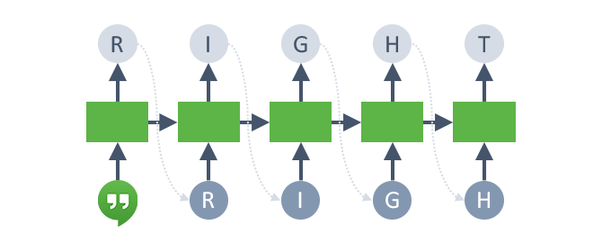

📌 Когда останавливается процесс генерации?

Если все время подавать модели на вход символ начала строки, то она будет предсказывать одну и ту же наиболее вероятную последовательность. Чтобы разнообразить генерацию, элементы последовательности берутся в соответствии с установленным распределением вероятностей.

### Случайная выборка из элементов массива `np.random.choice`

Метод `np.random.choice` выбирает из списка элемент случайным образом. Если мы не задаем распределение вероятностей, то каждый элемент будет выбран примерно одинаковое количество раз.

In [ ]:
import numpy as np

In [ ]:
for i in range(20):
  print(np.random.choice([1,2,3]))

3
2
2
2
2
2
3
2
3
1
2
1
3
1
3
2
3
1
2
3


Распределение вероятностей может быть задано эксплицитно. Если это ohe-hot вектор, то всегда будет выбираться номер позиции, на которой стоит 1.

In [ ]:
p1 = torch.nn.functional.one_hot(torch.tensor(2), 29)
print(p1)

tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0])


In [ ]:
for i in range(20):
  pred_id = np.random.choice(np.arange(len(dinos_dataset.char2id)), p=p1)
  print(pred_id)

2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


Можно использовать распределение вероятностей, которое было получено при обучении сети. Для этого необходимо к выходным данным применить функцию активации softmax.

In [ ]:
logits = y_pred[:, -1, :].unsqueeze(1)
print(logits.shape)
print(logits)
y_softmax_scores = torch.softmax(logits, dim=2)
print(y_softmax_scores.shape)
print(y_softmax_scores)
torch.sum(y_softmax_scores)

torch.Size([1, 1, 29])
tensor([[[-0.2236,  0.2948, -0.2065, -0.1341, -0.1287, -0.0941,  0.0792,
          -0.2618,  0.1939,  0.2477,  0.0915,  0.0381,  0.1490,  0.1228,
          -0.1779,  0.1854,  0.1844, -0.1777, -0.0067, -0.1234, -0.1257,
          -0.2145, -0.1227,  0.0942,  0.0631, -0.1771,  0.1408, -0.0562,
          -0.0910]]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)
torch.Size([1, 1, 29])
tensor([[[0.0276, 0.0464, 0.0281, 0.0302, 0.0304, 0.0315, 0.0374, 0.0266,
          0.0420, 0.0443, 0.0379, 0.0359, 0.0401, 0.0391, 0.0289, 0.0416,
          0.0416, 0.0289, 0.0343, 0.0305, 0.0305, 0.0279, 0.0306, 0.0380,
          0.0368, 0.0290, 0.0398, 0.0327, 0.0316]]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

In [ ]:
p2 = y_softmax_scores.detach().cpu().numpy().ravel()
print(p2)

[0.02763673 0.04640971 0.02811168 0.03022186 0.03038556 0.03145604
 0.03740957 0.0265993  0.04195486 0.04427475 0.03786988 0.0359011
 0.04011228 0.03907479 0.02892844 0.04160132 0.04155811 0.02893328
 0.03432857 0.0305476  0.03047702 0.02788901 0.03057042 0.03797352
 0.03681028 0.02895127 0.03978673 0.03267102 0.03155526]


In [ ]:
for i in range(20):
  pred_id = np.random.choice(np.arange(len(dinos_dataset.char2id)), p=p2)
  print(pred_id)

5
8
5
3
2
15
15
12
24
16
23
13
5
7
6
8
12
28
8
28


### Тестирование модели

Напишем функцию для генерации названий динозавров.

In [ ]:
def inference(dataset, model):
  model.eval() # переводим модель в состояние тестирования
  newline_id = dataset.char2id['>'] # записываем индекс символа конца последовательности
  word_size = 0 # будем контролировать длину порождаемой последовательности
  with torch.no_grad():
    state_h, state_c = (None, None) # скрытые состояния будут передаваться вручную, поэтому их надо хранить
    start_id = dataset.char2id['<'] # генерация начинается с символа начала последовательности
    indices = [start_id] # создаем список, где будем хранить предсказания
    word_size += 1 # увеличиваем длину последовательности
    pred_id = start_id # записываем символ начала последовательности как первое предсказание
    x = torch.tensor([[pred_id]]).to(device) # преобразуем в тензор

    """
    Будем использовать два условия для продолжения генерации в цикле while:
    1) сгенерированный символ не является символом конца последовательности '>'
    и
    2) длина сгенерированной последовательности меньше 20
    """
    while pred_id != newline_id and word_size < 20: # Место для вашего кода
      logits, (state_h, state_c) = model(x, (state_h, state_c)) # передаем в модель тензор с текущим символом x, предыдущие состояния h и c
      y_softmax_scores = torch.softmax(logits, dim=2) # применяем softmax к предсказаниям модели
      pred_id = np.random.choice( # осуществляем случайную выборку значений из заданного массива
          np.arange(len(dinos_dataset.char2id)), # с некоторой вероятностью получим один из 29 индексов
          p=y_softmax_scores.detach().cpu().numpy().ravel() # вероятность определяется в зависимости от обучающих данных
          )
      indices.append(pred_id) # добавляем предсказанный индекс в список предсказаний
      x = torch.tensor([[pred_id]]).to(device) # преобразуем в тензор
      word_size += 1 # увеличиваем длину последовательности

      if word_size == 20 and indices[-1] != newline_id:
        indices.append(newline_id)

    model.train()

    return ''.join([dinos_dataset.id2char[i] for i in indices]) # возвращаем индексы, переведенные в символы

### Обучение модели

In [ ]:
def train(dataset, dataloader, model, criterion, optimizer, max_epochs):
  model.train() # переводим модель в состояние обучения
  losses = []
  for epoch in range(max_epochs):
    print(f'\nEpoch {epoch+1}')
    epoch_loss = 0
    for batch, (x,y) in enumerate(dataloader):
      optimizer.zero_grad()
      y_pred, (state_h, state_c) = model(x) # передаем данные в модель, записываем предсказание
      loss = criterion(y_pred.transpose(1,2), y) # считаем ошибку
      epoch_loss += loss.item()
      loss.backward()
      optimizer.step()
      if (batch+1) % 100 == 0:
        print(inference(dataset, model))

    print(f'Loss {epoch_loss/(batch+1)}')
    losses.append(epoch_loss/(batch+1))
  return losses

In [ ]:
from torch import optim

In [ ]:
model = LM(len(dinos_dataset.char2id)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.2)
max_epochs = 15

In [ ]:
losses = train(dinos_dataset,dinos_dataloader, model, criterion, optimizer, max_epochs)


Epoch 1
<coiuovou>
<aunvctbotsuxoonu>
<m>
<iroinuuulrulao>
<s>
<lseucuiau>
<saocuuanaz>
<nghssriruuonacplsoi>
<
oao<celmruupucrrtu>
<noerbahou>
<ah>
<iuusoosam
tuoos>
<erras>
<hna>
<chuhaios>
Loss 2.738368986795346

Epoch 2
<otgasikurwtiauynure>
<rorusan>
<lijarururabvazta>
<li>
<urydasopongntoraxyo>
<a>
<ctoruroau
tig>
<baukerururuprus>
<<cgonaar>
<mchidops>
<cis>
<cyurus>
<modyprvauwiaxapibid>
<prosaniatalaulasaur>
<ceniganmopnutirurau>
Loss 2.3165668315098933

Epoch 3
<a>
<ctopoptausin>
<hororrura>
<rmaus>
<opltosauros>
<nonys>
<chiopopiangosngmus>
<bocrurusas>
<aneicgciacengolysat>
<aenatos>
<ctagosiltonyurus>
<eos>
<ogdorusangloraxausv>
<uiorus>
<ochitosururukarurun>
Loss 2.2573755936852344

Epoch 4
<myros>
<nisaurustips>
<hosargczausaurururu>
<xekusaususapecs>
<tostotyngus>
<s>
<eoalosaneromaurycop>
<s>
<kekatos>
<melusauraususicitou>
<bilanprophncon>
<dinanmesarenrosacha>
<treraururustiteauru>
<ningur>
<mitatarururuntoptru>
Loss 2.2366965548911444

Epoch 5
<his>
<lanosauruspglo

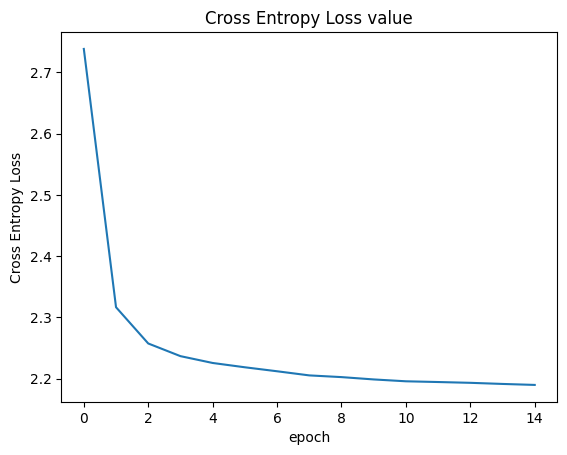

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.title('Cross Entropy Loss value')
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch')
plt.show()

📌 Как оценивать качество языковых моделей? Какие могут быть метрики кроме значения функции потерь?